In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, Xception, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Veri seti yolu
data_path = 'C:/Users/Andac/Desktop/dockerAndac/meyveçürük'
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

train_generator = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
)

val_generator = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
)

# Sanal bir test veri seti oluştur
fake_test_generator = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Early stopping için callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Determine number of classes
num_classes = train_generator.num_classes

def build_xception():
    xception_model = Xception(include_top=False, input_shape=(224, 224, 3))
    for layer in xception_model.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(xception_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(units=80, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=1e-8),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

def build_inceptionv3():
    inception_model = InceptionV3(include_top=False, input_shape=(224, 224, 3))
    for layer in inception_model.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(inception_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(units=96, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=4e-8),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

def build_mobilenetv2():
    mobilenetv2_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3))
    for layer in mobilenetv2_model.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(mobilenetv2_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(units=128, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=5e-7),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Modelleri oluştur
mobilenetv2_model = build_mobilenetv2()
xception_model = build_xception()
inceptionv3_model = build_inceptionv3()


mobilenetv2_history = mobilenetv2_model.fit(train_generator, validation_data=val_generator, epochs=60, callbacks=[early_stopping])
xception_history = xception_model.fit(train_generator, validation_data=val_generator, epochs=60, callbacks=[early_stopping])
inceptionv3_history = inceptionv3_model.fit(train_generator, validation_data=val_generator, epochs=60)



Found 11749 images belonging to 12 classes.
Found 2933 images belonging to 12 classes.
Found 2933 images belonging to 12 classes.
Epoch 1/60
368/368 [==============================] - 55s 138ms/step - loss: 2.8841 - accuracy: 0.0950 - val_loss: 2.7301 - val_accuracy: 0.1289
Epoch 2/60
368/368 [==============================] - 50s 135ms/step - loss: 2.7842 - accuracy: 0.1054 - val_loss: 2.6405 - val_accuracy: 0.1401
Epoch 3/60
368/368 [==============================] - 49s 134ms/step - loss: 2.6915 - accuracy: 0.1216 - val_loss: 2.5574 - val_accuracy: 0.1510
Epoch 4/60
368/368 [==============================] - 50s 134ms/step - loss: 2.6114 - accuracy: 0.1375 - val_loss: 2.4791 - val_accuracy: 0.1664
Epoch 5/60
368/368 [==============================] - 50s 135ms/step - loss: 2.5312 - accuracy: 0.1573 - val_loss: 2.4056 - val_accuracy: 0.1862
Epoch 6/60
368/368 [==============================] - 50s 134ms/step - loss: 2.4571 - accuracy: 0.1720 - val_loss: 2.3358 - val_accuracy: 0.2090


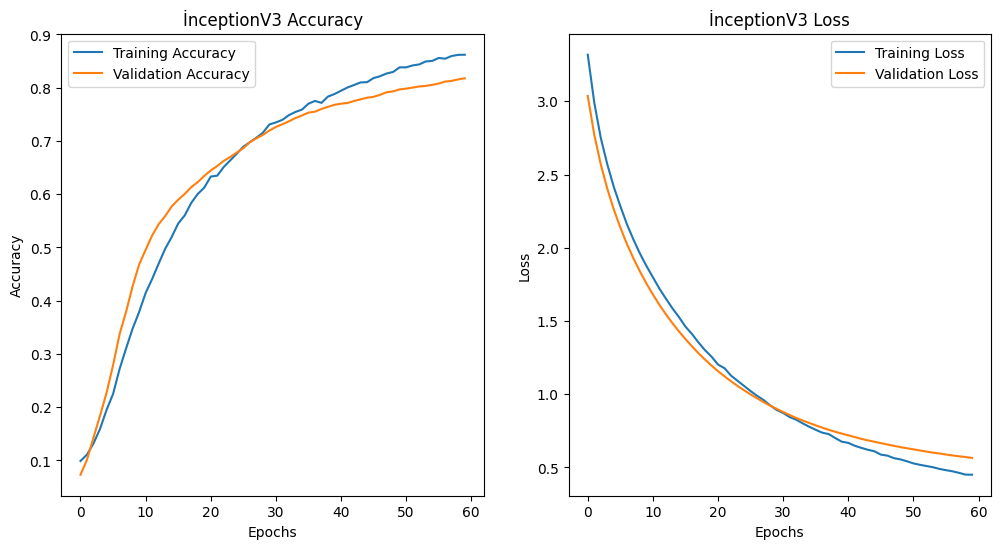

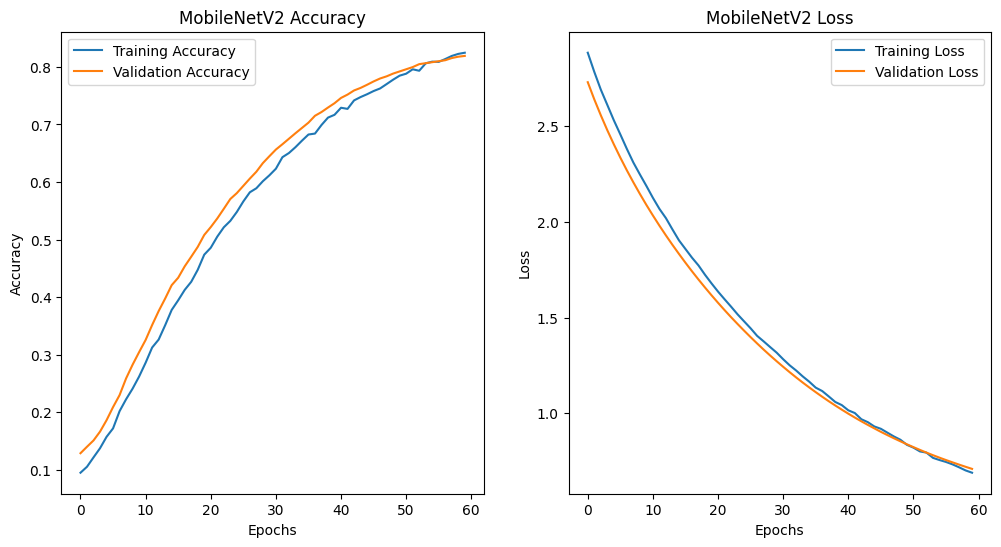

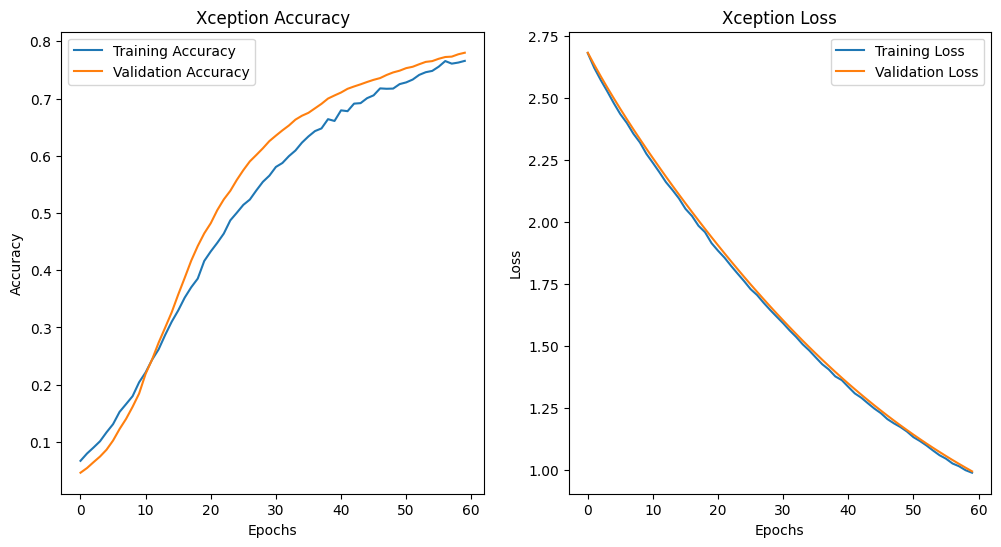

In [2]:
# Grafik çizimi
def plot_history(history, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Modellerin Eğitim Sonuçlarını Çiz
plot_history(inceptionv3_history, title='İnceptionV3')
plot_history(mobilenetv2_history, title='MobileNetV2')
plot_history(xception_history, title='Xception')


In [5]:
# Test seti etiketlerini yükle
fake_test_labels = fake_test_generator.classes

# Modelleri ensemble etme
models = [inceptionv3_model, xception_model, mobilenetv2_model]  
weights = [0.4, 0.3, 0.3]  # Ağırlıklar

# Ensemble tahminlerini ağırlıklı olarak oluşturma
predictions_list = []
for model in models:
    predictions = model.predict(fake_test_generator, verbose=1)
    predictions_list.append(predictions)

weighted_predictions = np.zeros_like(predictions_list[0])
for predictions, weight in zip(predictions_list, weights):
    weighted_predictions += predictions * weight

ensemble_labels = np.argmax(weighted_predictions, axis=1)

# Toplam tahmin sayısına göre bir matris oluştur
ensemble_predictions = np.zeros((fake_test_generator.samples, 12))  

# Tahminleri ve ağırlıkları kullanarak toplam tahmini hesapla
for predictions, weight in zip(predictions_list, weights):
    ensemble_predictions += predictions * weight

# Final tahminler (en yüksek skoru olan sınıfın indeksini al)
final_predictions = np.argmax(ensemble_predictions, axis=1)

# Performans metriklerini hesapla
accuracy_weighted = accuracy_score(fake_test_labels, final_predictions)
recall_weighted = recall_score(fake_test_labels, final_predictions, average='macro')
precision_weighted = precision_score(fake_test_labels, final_predictions, average='macro')
# Ensemble için F1 skorunu formülle hesapla
f1_weighted_direct = 2 * (precision_weighted * recall_weighted) / (precision_weighted + recall_weighted + 1e-15)

print(f'Ensemble Accuracy: {accuracy_weighted}')
print(f'Ensemble Recall: {recall_weighted}')
print(f'Ensemble Precision: {precision_weighted}')
print(f'Ensemble F1 Score: {f1_weighted_direct}')

# Her bir modelin ayrı ayrı değerlendirmesi
def evaluate_model(model, model_name):
    predictions = model.predict(fake_test_generator)
    predictions_classes = np.argmax(predictions, axis=1)
    f1 = 2 * (precision_score(fake_test_labels, predictions_classes, average='macro') * recall_score(fake_test_labels, predictions_classes, average='macro')) / (precision_score(fake_test_labels, predictions_classes, average='macro') + recall_score(fake_test_labels, predictions_classes, average='macro') + 1e-15)
    evaluation = model.evaluate(fake_test_generator)
    print(f"\n{model_name} Model Değerlendirmesi:")
    print("Loss:", evaluation[0])
    print("Accuracy:", evaluation[1])
    print("Precision:", precision_score(fake_test_labels, predictions_classes, average='macro'))
    print("Recall:", recall_score(fake_test_labels, predictions_classes, average='macro'))
    print("F1 Score:", f1)
    print("Classification Report:")
    print(classification_report(fake_test_labels, predictions_classes))

evaluate_model(inceptionv3_model, "InceptionV3")
evaluate_model(xception_model, "Xception")
evaluate_model(mobilenetv2_model, "MobileNetV2")


92/92 [==============================] - 11s 121ms/step
Ensemble Accuracy: 0.8571428571428571
Ensemble Recall: 0.8288413324562435
Ensemble Precision: 0.844760378517475
Ensemble F1 Score: 0.8367251457090071
92/92 [==============================] - 13s 140ms/step - loss: 0.5652 - accuracy: 0.8176

InceptionV3 Model Değerlendirmesi:
Loss: 0.565169095993042
Accuracy: 0.8175929188728333
Precision: 0.7918334349521198
Recall: 0.7771242675230964
F1 Score: 0.7844099011294836
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       338
           1       0.97      0.96      0.97       316
           2       0.88      0.82      0.85        65
           3       0.47      0.74      0.58       198
           4       0.85      0.97      0.91       293
           5       0.98      0.91      0.94       196
           6       0.80      0.94      0.87       468
           7       0.95      0.92      0.94       293
           8       

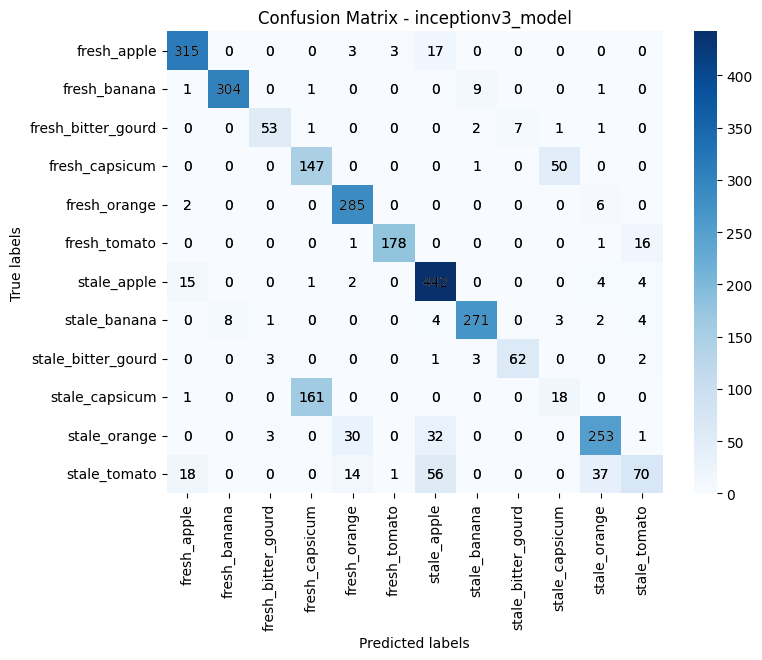

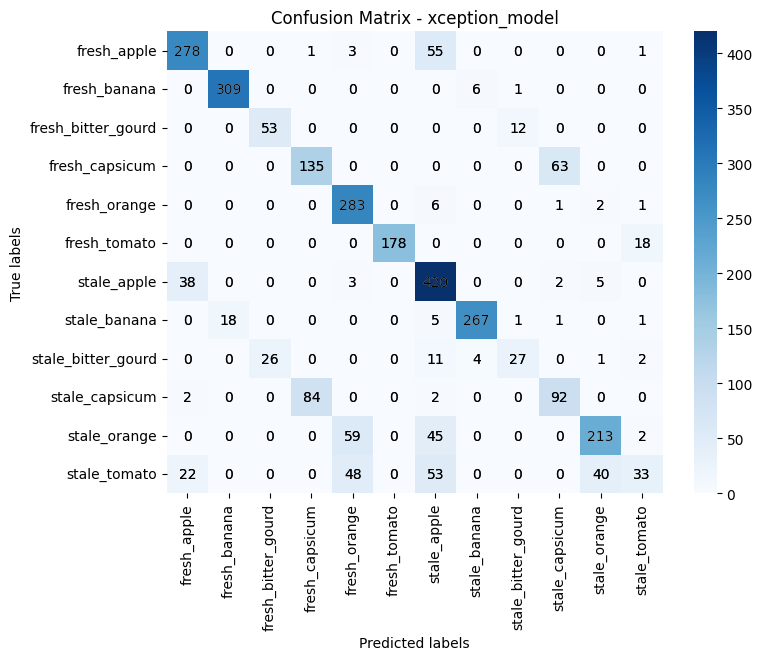

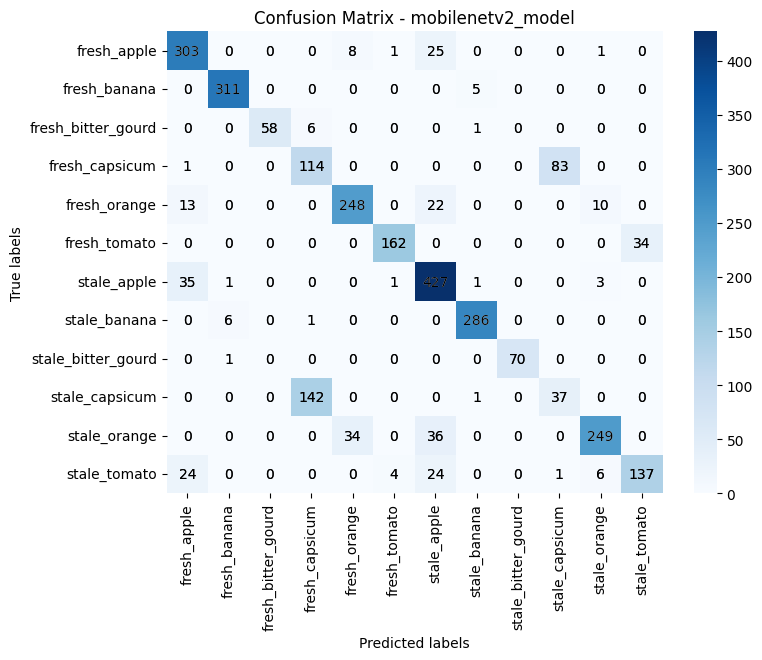

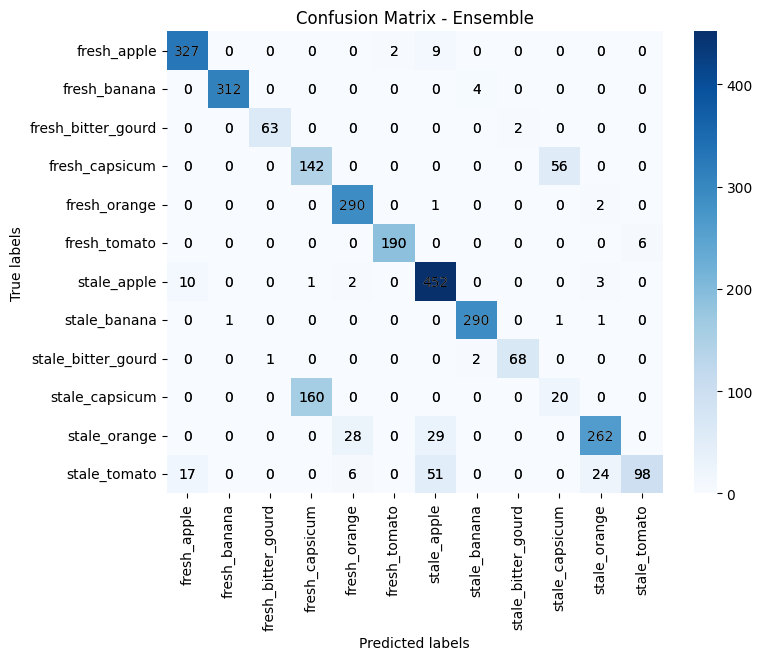

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

model_names = ['inceptionv3_model', 'xception_model','mobilenetv2_model']
for idx, predictions in enumerate(predictions_list):
    cm = confusion_matrix(val_generator.classes, np.argmax(predictions, axis=1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
    plt.title(f'Confusion Matrix - {model_names[idx]}')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    for i in range(len(val_generator.class_indices)):
        for j in range(len(val_generator.class_indices)):
            plt.text(j+0.5, i+0.5, cm[i, j], ha='center', va='center', color='black')
    plt.show()

# Ensemble learning için confusion matrix oluştur
ensemble_cm = confusion_matrix(val_generator.classes, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(ensemble_cm, cmap='Blues', annot=True, fmt='d', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title('Confusion Matrix - Ensemble')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
for i in range(len(val_generator.class_indices)):
    for j in range(len(val_generator.class_indices)):
        plt.text(j+0.5, i+0.5, ensemble_cm[i, j], ha='center', va='center', color='black')
plt.show()




1/1 [==============================] - 1s 1s/step


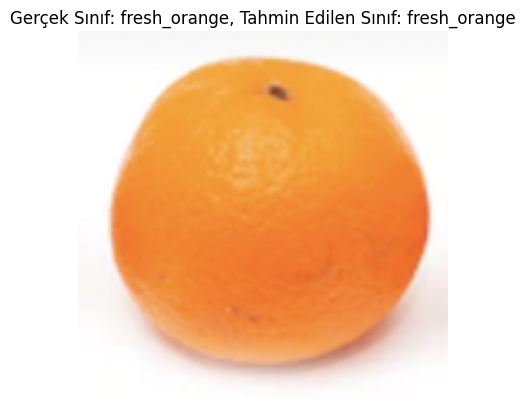

1/1 [==============================] - 0s 27ms/step


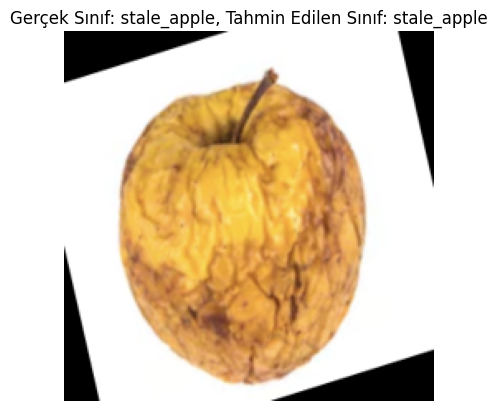

1/1 [==============================] - 0s 61ms/step


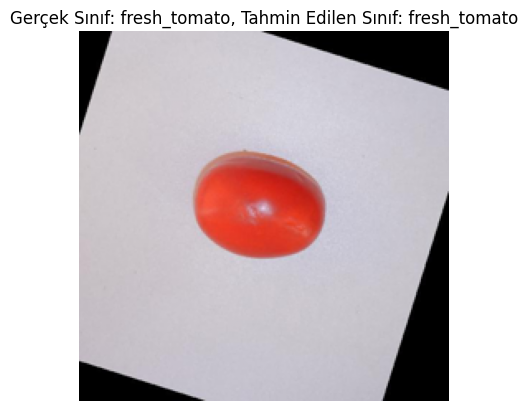

1/1 [==============================] - 0s 27ms/step


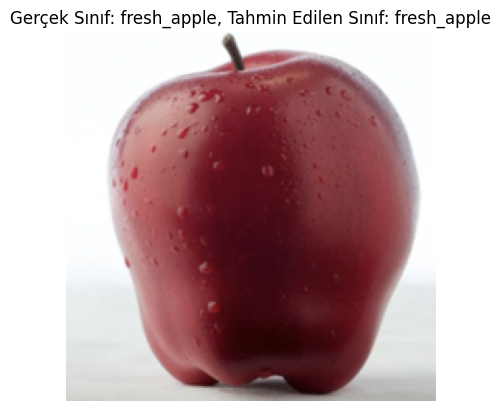

1/1 [==============================] - 0s 28ms/step


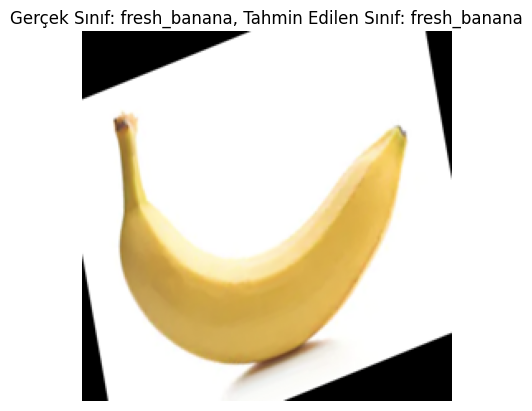

1/1 [==============================] - 0s 26ms/step


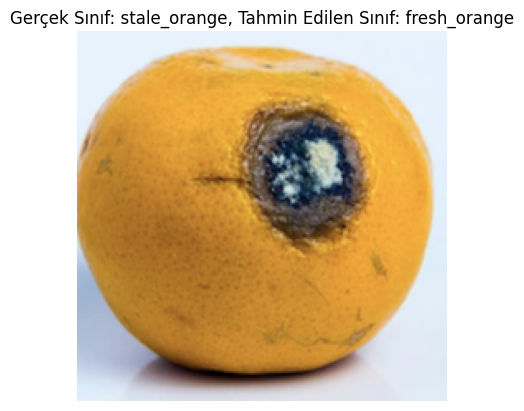

1/1 [==============================] - 0s 27ms/step


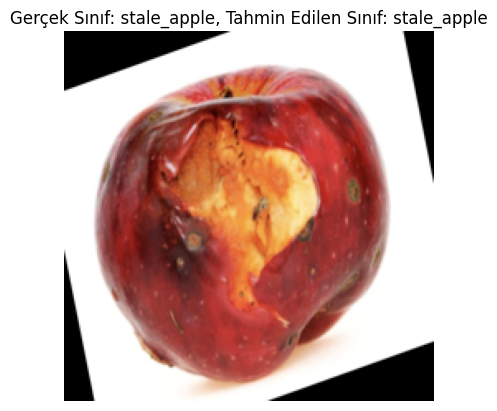

1/1 [==============================] - 0s 30ms/step


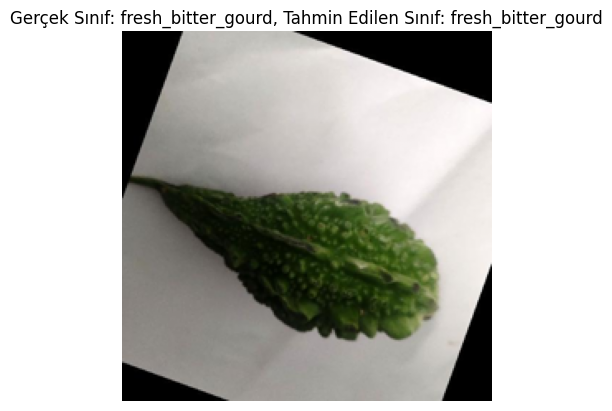

1/1 [==============================] - 0s 26ms/step


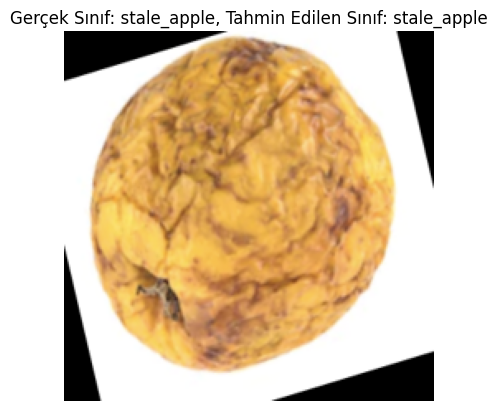

1/1 [==============================] - 0s 28ms/step


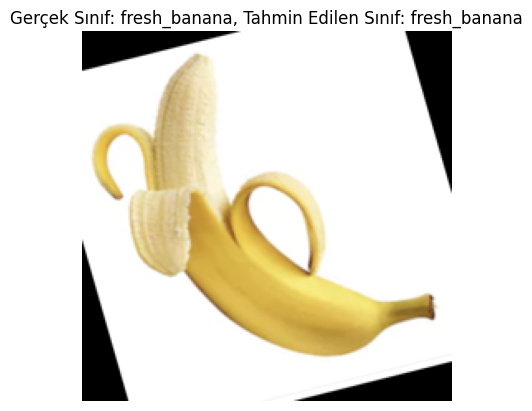

Toplam doğruluk: 0.9


In [7]:
import random
from PIL import Image

# Sınıf isimlerini al
class_names = list(fake_test_generator.class_indices.keys())

# Rastgele 10 görüntü seçme
random_image_paths = random.sample(fake_test_generator.filepaths, 10)

# Seçilen görüntülerin gerçek etiketleri ve tahminlerini tutacak listeler oluşturma
true_labels = []
predicted_labels = []

# Seçilen görüntüler için tahminler yapma
for image_path in random_image_paths:
    # Görüntüyü yükleme
    image = Image.open(image_path)
    
    # Dört kanallı görüntüyü üç kanallıya dönüştürme
    image = image.convert('RGB')

    # Görüntüyü model için uygun boyuta yeniden boyutlandırma ve normalizasyon
    image = image.resize((224, 224))  # Model için gerekli boyuta yeniden boyutlandırma
    image = np.array(image) / 255.0  # Normalizasyon

    # Tahmin yapma
    predictions = np.zeros((1, len(class_names)))  # Ensemble model için tahmin matrisi oluşturma
    for model, weight in zip(models, weights):
        prediction = model.predict(np.expand_dims(image, axis=0)) * weight
        predictions += prediction

    # En yüksek skoru olan sınıfın indeksini alarak tahmin etiketini bulma
    predicted_label_index = np.argmax(predictions)
    predicted_label = class_names[predicted_label_index]  # Tahmin edilen etiketi isme dönüştürme

    # Gerçek etiketi alarak isme dönüştürme
    true_label_index = fake_test_generator.classes[fake_test_generator.filepaths.index(image_path)]
    true_label = class_names[true_label_index]  # Gerçek etiketi isme dönüştürme

    # Gerçek ve tahmin edilen etiketleri listelere ekleme
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

    # Görüntüyü ekrana bastırma
    plt.imshow(image)
    plt.title(f"Gerçek Sınıf: {true_label}, Tahmin Edilen Sınıf: {predicted_label}")
    plt.axis('off')
    plt.show()

# Doğruluk hesaplama
accuracy = accuracy_score(true_labels, predicted_labels)
print("Toplam doğruluk:", accuracy)


In [9]:
mobilenetv2_model.summary()
inceptionv3_model.summary()
xception_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                1548      
                                                                 
Total params: 2,423,500
Trainable params: 165,516
Non-tr

1/1 [==============================] - 0s 27ms/step


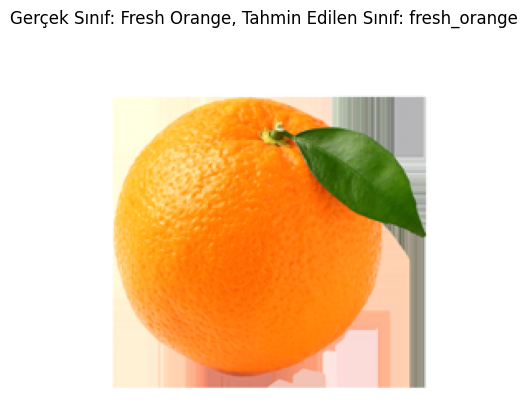

1/1 [==============================] - 0s 28ms/step


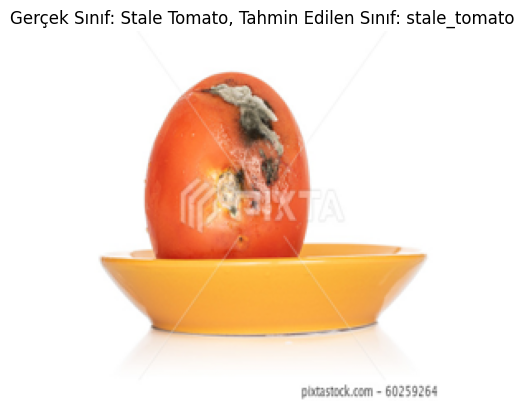

1/1 [==============================] - 0s 28ms/step


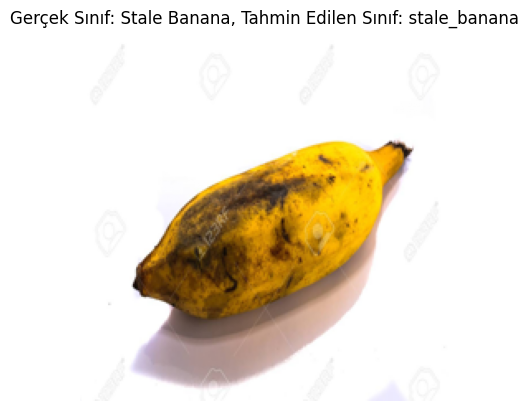

1/1 [==============================] - 0s 27ms/step


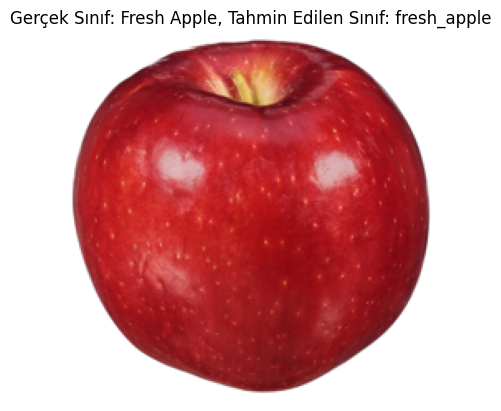

1/1 [==============================] - 0s 29ms/step


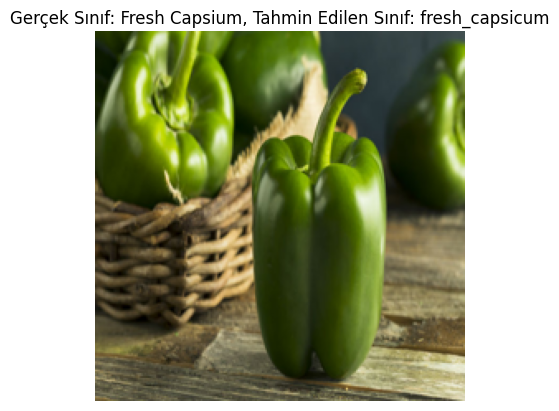

In [10]:
# Kullanıcı tarafından belirlenen iki özel görüntü
base_dir = 'C:/Users/Andac/Desktop/VERİSETLERİVE KODLAR'  # Dosya yolunu burada belirleyin

custom_image_paths = [
    os.path.join(base_dir, "orange.png"),
    os.path.join(base_dir, "tomato.jpg"),
    os.path.join(base_dir, "banana.jpg"),
    os.path.join(base_dir, "apple.jpeg"),
    os.path.join(base_dir, "Bell-pepper.jpg")
]
custom_true_labels = ["Fresh Orange", "Stale Tomato", "Stale Banana","Fresh Apple","Fresh Capsium"]  # Bu etiketleri gerçek sınıflarla güncelleyin

# Özel görüntüler için tahminler yapma
for custom_image_path, custom_true_label in zip(custom_image_paths, custom_true_labels):
    # Görüntü yolunun var olup olmadığını kontrol etme
    if not os.path.exists(custom_image_path):
        print(f"Dosya bulunamadı: {custom_image_path}")
        continue
    
    # Görüntüyü yükleme
    image = Image.open(custom_image_path)
    
    # Dört kanallı görüntüyü üç kanallıya dönüştürme
    image = image.convert('RGB')

    # Görüntüyü model için uygun boyuta yeniden boyutlandırma ve normalizasyon
    image = image.resize((224, 224))  # Model için gerekli boyuta yeniden boyutlandırma
    image = np.array(image) / 255.0  # Normalizasyon

    # Tahmin yapma
    predictions = np.zeros((1, len(class_names)))  # Ensemble model için tahmin matrisi oluşturma
    for model, weight in zip(models, weights):
        prediction = model.predict(np.expand_dims(image, axis=0)) * weight
        predictions += prediction

    # En yüksek skoru olan sınıfın indeksini alarak tahmin etiketini bulma
    predicted_label_index = np.argmax(predictions)
    predicted_label = class_names[predicted_label_index]  # Tahmin edilen etiketi isme dönüştürme

    # Görüntüyü ekrana bastırma
    plt.imshow(image)
    plt.title(f"Gerçek Sınıf: {custom_true_label}, Tahmin Edilen Sınıf: {predicted_label}")
    plt.axis('off')
    plt.show()